In [1]:
%load_ext rpy2.ipython

# Notebook 9
#### 17.05 - Reproduce Oliver
#### 21.05 - Updated (with new spatial measure)

In the paper from Oliver, they wanted to represent a worldwide trend of the association between coral cover and heat by using Linear Mixed Models (LMM) where they added **random factors//additional variables** where each observation comes from.

This enables the model to first check for baseline difference between regions and tries to explain the differences with respect to temperature ect....
- The ocean region
- The study areas
- Survey sites located up to 100 km of distance from each other (corresponds to average value of the mean Euclidian distances measured between survey sites) // ours will be smaller here 
- Survey sites located up to 7 km (minimal Euclidian distances between survey sites)

Instead of having 4 random factors we will have 3 because all our variables are located within the same Oceanic region 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import pyproj as proj
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import data_processing_helper as dp
import practical_functions as pf
import geoplot
import geoplot as gplt
import warnings
from matplotlib import cm
warnings.filterwarnings("ignore")


####
# For categorical encoding
from sklearn.preprocessing import OrdinalEncoder
# Compute the distances between all surveys 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import ward, fcluster


import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
def save_rdata_file(df, filename, assign_name):
    r_data = df
    robjects.r.assign(format(f"{assign_name}"), r_data)
    robjects.r(format(f"save({assign_name}, file='{filename}')"))

In [4]:
df = pd.read_csv("../Data/df_all_17_05.csv")
dp.geo_loads(df)
df = pf.make_geo_frame(df)

In [5]:

df_fish_2012_bef = df[(df["year"] == 2012)].join(pd.DataFrame(df["fish_hours_2012"]), rsuffix="prev_")["fish_hours_2012prev_"]
df_fish_2014_bef = df[(df["year"] == 2014)].join(pd.DataFrame(df["fish_hours_2014"]), rsuffix="prev_")["fish_hours_2014prev_"]
df_fish_2016_bef = df[(df["year"] == 2016)].join(pd.DataFrame(df["fish_hours_2016"]), rsuffix="prev_")["fish_hours_2016prev_"]
df_fish_2017_bef = df[(df["year"] == 2017)].join(pd.DataFrame(df["fish_hours_2017"]), rsuffix="prev_")["fish_hours_2017prev_"]
df["Fishing_hours"] = np.NaN

df_nigh_2012_bef = df[(df["year"] == 2012)].join(pd.DataFrame(df["nigh_avg_2012"]), rsuffix="_bef")["nigh_avg_2012_bef"]
df_nigh_2013_bef = df[(df["year"] == 2013)].join(pd.DataFrame(df["nigh_avg_2013"]), rsuffix="_bef")["nigh_avg_2013_bef"]
df_nigh_2014_bef = df[(df["year"] == 2014)].join(pd.DataFrame(df["nigh_avg_2014"]), rsuffix="_bef")["nigh_avg_2014_bef"]
df_nigh_2015_bef = df[(df["year"] == 2015)].join(pd.DataFrame(df["nigh_avg_2015"]), rsuffix="_bef")["nigh_avg_2015_bef"]
df_nigh_2016_bef = df[(df["year"] == 2016)].join(pd.DataFrame(df["nigh_avg_2016"]), rsuffix="_bef")["nigh_avg_2016_bef"]
df_nigh_2017_bef = df[(df["year"] == 2017)].join(pd.DataFrame(df["nigh_avg_2017"]), rsuffix="_bef")["nigh_avg_2017_bef"]
df["NightLights"] = np.NaN


In [6]:
test_fish = df.join(df_fish_2012_bef ).join(df_fish_2014_bef).join(df_fish_2016_bef).join(df_fish_2017_bef)


In [7]:
test_fish.replace(np.nan,0, inplace = True)

In [8]:
test_night = df.join(df_nigh_2012_bef ).join(df_nigh_2013_bef).join(df_nigh_2014_bef).join(df_nigh_2015_bef).join(df_nigh_2016_bef).join(df_nigh_2017_bef)
test_night.replace(np.nan,0, inplace = True)

In [9]:
df["NightLights"] = test_night["nigh_avg_2012_bef"] + test_night["nigh_avg_2013_bef"] + test_night["nigh_avg_2014_bef"] + test_night["nigh_avg_2015_bef"] + test_night["nigh_avg_2016_bef"] + test_night["nigh_avg_2017_bef"]
df["Fishing_hours"] = test_fish["fish_hours_2012prev_"] + test_fish["fish_hours_2014prev_"] + test_fish["fish_hours_2016prev_"] + test_fish["fish_hours_2017prev_"]

### Define the three random factors which will be used in the generalized linear mixture model
- Study areas (4 levels)
- Survey sites located up to average distance
- Survey sites located up to min 

In [10]:
ord_enc = OrdinalEncoder()
df["country_code"] = ord_enc.fit_transform(df[["country"]])

#AUS - 0
# IDN - 1
# SLB - 2
# TLS - 3

In [11]:
# Study areas
df.drop(columns = "country", inplace = True)

In [12]:
## Only keep different places else the distances between those will be very small // Different transectID

In [13]:
df_diff_surveys = df.drop_duplicates(subset='transectid', keep='first')

In [14]:
df_diff_surveys.drop(columns = "geometry", inplace = True)

In [15]:
with localconverter(ro.default_converter + pandas2ri.converter):
    
    df_diff_r = ro.conversion.py2rpy(df_diff_surveys)
save_rdata_file(df_diff_r, "df_diff_r.rda", "df_diff_id")

In [16]:
with localconverter(ro.default_converter + pandas2ri.converter):
    
    df_all_R = ro.conversion.py2rpy(df.drop(columns = "geometry"))
save_rdata_file(df_all_R, "df_all_r.rda", "df_all_id")

In [17]:
%%R
    library("SoDA")
    load('df_diff_r.rda', verbose = TRUE)
    ### Convert coordinates on cartesian system
    coordXY = geoXY(df_diff_id$lat, df_diff_id$lon, lat0 = 0, lon0 = 0)
    # Compute euclidean distance
    s.Dist = as.matrix(dist(coordXY))
    write.csv(s.Dist, "distance_diff_survey.csv", row.names = FALSE)
    
    load('df_all_r.rda',verbose = TRUE)
    coordXY_all = geoXY(df_all_id$lat, df_all_id$lon, lat0 = 0, lon0 = 0)
    # Compute euclidean distance
    s_all.Dist = as.matrix(dist(coordXY_all))
    write.csv(s_all.Dist, "distance_all_surveys.csv", row.names = FALSE)
    

Loading objects:
  df_diff_id
Loading objects:
  df_all_id


In [18]:
X_dist = pd.read_csv("distance_diff_survey.csv")
X_condensed = squareform(X_dist)
Z_R = ward(X_condensed)

Text(0.5, 1.0, 'Distribution of distances between surveys')

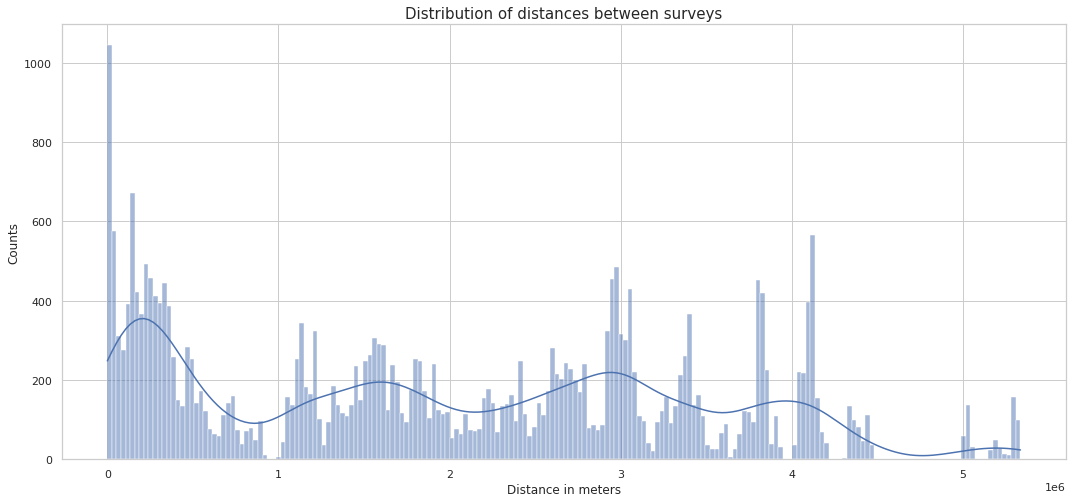

In [19]:
plt.figure(figsize = (18,8))
sns.histplot(X_condensed, bins = 200, kde = True)
plt.xlabel("Distance in meters")
plt.ylabel("Counts")
plt.title("Distribution of distances between surveys", fontsize = 15)


### Look at peaks and set break to seprate localities
Then divide by two because it's distances and thus we looking at a radiius

In [20]:
3e6/2

1500000.0

In [21]:
peak_1_hist = 10000
peak_2_hist = 1e6/2
peak_3_hist = 3e6/2
peak_4_hist = 4.4e6/2

In [22]:
X_dist_all = pd.read_csv("distance_all_surveys.csv")
X_condensed_all = squareform(X_dist_all)
Z_all = ward(X_condensed_all)

In [23]:
peak1_clusters = fcluster(Z_all, peak_1_hist, criterion='distance')
peak2_clusters = fcluster(Z_all, peak_2_hist, criterion='distance')
peak3_clusters = fcluster(Z_all, peak_3_hist, criterion='distance')
peak4_clusters = fcluster(Z_all, peak_4_hist, criterion='distance')

In [24]:
#df["local_clusters"]= local_clusters
#df["regional_clusters"]= regional_clusters
df["peak1_clusters"] = peak1_clusters
df["peak2_clusters"] = peak2_clusters
df["peak3_clusters"] = peak3_clusters

# We can remove peak 4 as it is representative of the same as peak3
df["peak4_clusters"] = peak4_clusters


In [25]:
def clust_plot(hue, size_peak_unique = None):
    size = size_peak_unique
    print(size)
    camp_home = cm.get_cmap('gist_rainbow', size)
    ax = gplt.webmap(df, figsize = (18,12))

    gplt.pointplot(
    df,
    hue=hue, ax = ax,cmap = camp_home,
    legend = True, legend_kwargs={'shrink': 0.45}
);

In [26]:
dp.swap_coordinates(df)
print("swaped Coordinates")

swaped Coordinates


In [27]:
with localconverter(ro.default_converter + pandas2ri.converter):
    
    df_peak_all = ro.conversion.py2rpy(df.drop(columns = "geometry"))
save_rdata_file(df_peak_all, "df_peak_all.rda", "df_peak_all")

In [29]:
# For plotting the clusters, computationally expensive
#clust_plot(peak1_clusters, len(np.unique(peak1_clusters)))
#clust_plot(peak3_clusters, len(np.unique(peak3_clusters)))
#clust_plot(peak2_clusters, len(np.unique(peak2_clusters)))

#clust_plot("country_code", df["country_code"].nunique())

In [30]:
df.to_csv("encoded_28_05.csv", index = False)


Now it's time to build the GLMM's with the response variable being hard coral cover, where you can use beta regression method to model their response

the five explanatory variables are the DHW averages

For univariate GLMM:
- Association between hard coral cover and DHW_1avg_year, DHW10 years and DHW 20 years
--> Goal: evaluate how local patterns of coral cover can be explained by recent and past heat stress





# Using R in Python

In [31]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')
from rpy2.robjects.vectors import StrVector

In [32]:
import rpy2
from rpy2.robjects.packages import importr
utils = importr("utils")
d = {'print.me': 'print_dot_me', 'print_me': 'print_uscore_me'}
try:
    visreg = importr('visreg', robject_translations = d, lib_loc = "/usr/local/lib/R/site-library")
    glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/usr/local/lib/R/site-library")
except:
    try:
        visreg = importr('visreg', robject_translations = d, lib_loc = "/usr/lib/R/site-library")
        glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/usr/lib/R/site-library")
    except:
        visreg = importr('visreg', robject_translations = d, lib_loc = "/home/lavinia/R/x86_64-pc-linux-gnu-library/3.6")
        glmmTMB = importr('glmmTMB', robject_translations = d, lib_loc = "/home/lavinia/R/x86_64-pc-linux-gnu-library/3.6")


Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

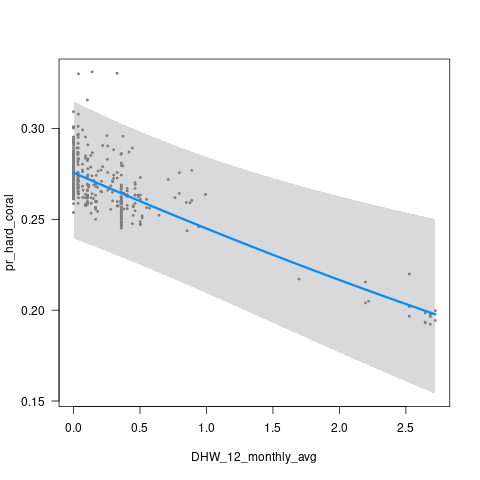

In [33]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ DHW_12_monthly_avg +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ DHW_120_monthly_avg +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD20 = glmmTMB(pr_hard_coral ~ DHW_240_monthly_avg +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    print("---------------20 YEARS------------------------------")
                    print(summary(MOD20))
                    visreg(MOD1, scale = 'response', partial=T)
                    

## Try modelling with other variables

### SST

Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

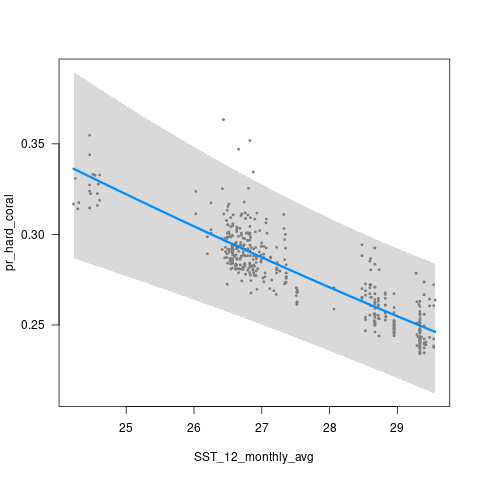

In [34]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ SST_12_monthly_avg +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ SST_120_monthly_avg +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD20 = glmmTMB(pr_hard_coral ~ SST_240_monthly_avg +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    print("---------------20 YEARS------------------------------")
                    print(summary(MOD20))
                    visreg(MOD1, scale = 'response', partial=T)

### Wind + SST average

Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

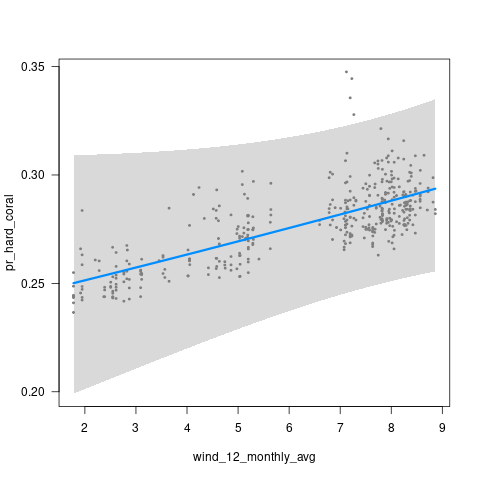

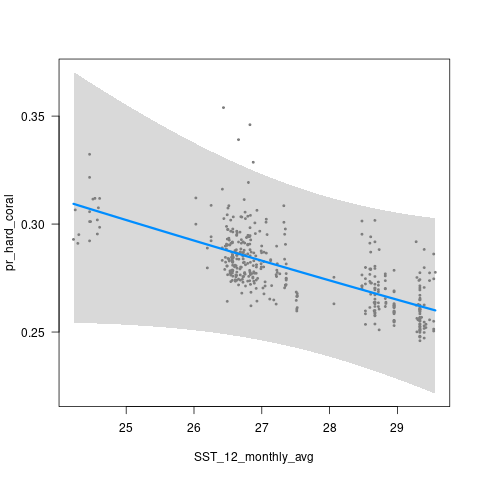

In [35]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ wind_12_monthly_avg + SST_12_monthly_avg +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ wind_120_monthly_avg + SST_120_monthly_avg+  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    
                    
                    
                    
    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                
                    visreg(MOD1, scale = 'response', partial=T)

### Max Wind speed

Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

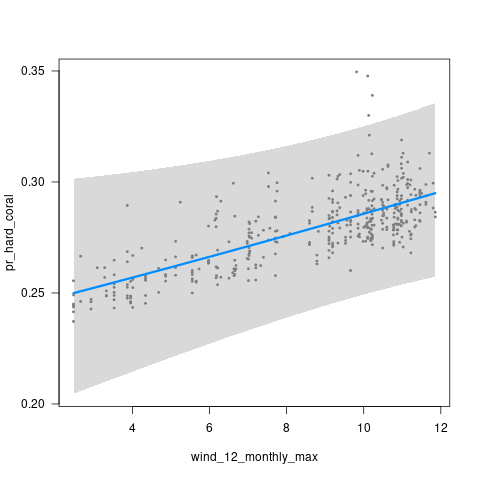

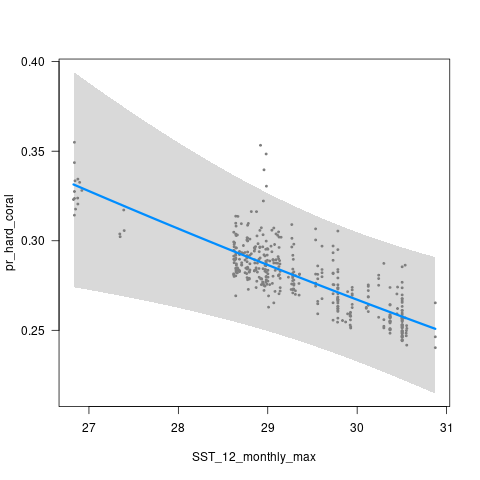

In [36]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ wind_12_monthly_max + SST_12_monthly_max+  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD10 = glmmTMB(pr_hard_coral ~ wind_120_monthly_max + SST_120_monthly_max+  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    print(summary(MOD10))
                    
                    visreg(MOD1, scale = 'response', partial=T)

### PAR // Cannot use due to lack of temporality

Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

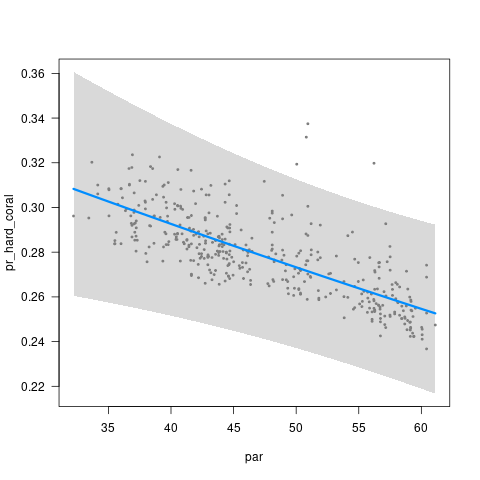

In [37]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ par +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    
                    
                    
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    
                    print("---------------20 YEARS------------------------------")
                    
                    visreg(MOD1, scale = 'response', partial=T)

### Chlorophyll //Missing temporal

Loading objects:
  df_peak_all
[1] "----------------NULL MODEL------------------"
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1045.8  -1021.6    528.9  -1057.8      410 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.958e-02 2.441e-01
 2.827e-02 1.682e-01
 1.682e-01 4.101e-01
 2.449e-09 4.949e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:

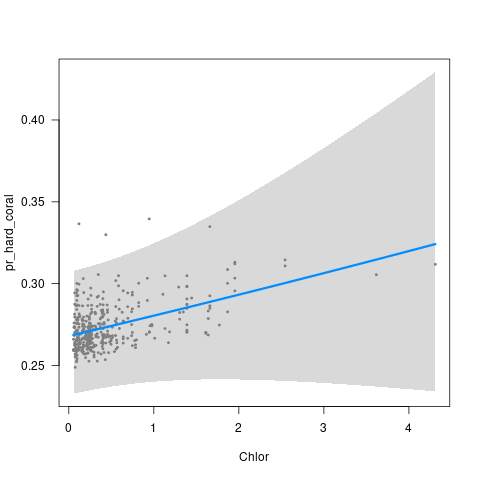

In [38]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ Chlor +  (1 |country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    
                    
                    
                    
                    
                    print("----------------NULL MODEL------------------")
                    print(summary(MOD0))
                    print("---------------1 YEAR-------------------------")
                    print(summary(MOD1))
                    print("---------------10 YEARS----------------------")
                    
                    print("---------------20 YEARS------------------------------")
                    
                    visreg(MOD1, scale = 'response', partial=T)

## Solar Radiation

In [39]:
(df["solar_all_year_avg"]).isna().sum()

291

### Elevation/ Depth

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ elevation + (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1043.9  -1015.7    528.9  -1057.9      409 

Random effects:

Conditional model:
 Groups                                                        Name       
 peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)) (Intercept)
 peak2_clusters:(peak3_clusters:country_code)                  (Intercept)
 peak3_clusters:country_code                                   (Intercept)
 country_code                                                  (Intercept)
 Variance  Std.Dev. 
 5.964e-02 2.442e-01
 2.901e-02 1.703e-01
 1.672e-01 4.089e-01
 4.451e-09 6.672e-05
Number of obs: 416, groups:  
peak1_clusters:(peak2_clusters:(peak3_clusters:country_code)), 97; peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:country_code, 8; country_code, 4

Overdispe

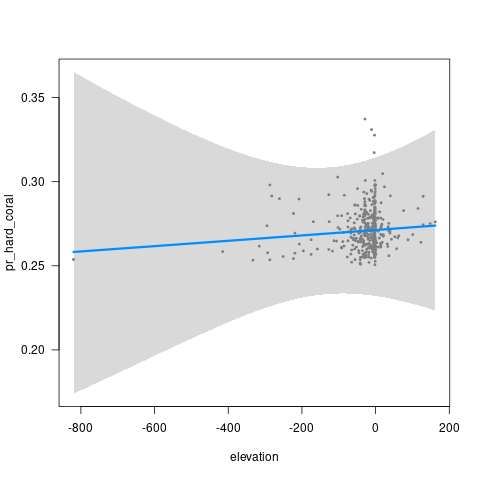

In [40]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ elevation + (1|country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ elevation + (1|country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    visreg(MOD1, scale = 'response', partial=T)
                    
                    print(summary(MOD0))
                    print(summary(MOD1))
                    


# Distance to marine protected area // Check other stats
Actually for me it does not make sense to think of distance as a stat evaluated with a country/regional/local because it just really depends on the distance

In [41]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    #MOD0 = glmmTMB(pr_hard_coral ~ 1+  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    model = glmmTMB(pr_hard_coral ~ dist_marine_protection ,data=df_peak_all,family=beta_family())
                    
                    #visreg(MOD1, scale = 'response', partial=T)
                    
                
                    #library(betareg)
                    #model = betareg(pr_hard_coral ~ dist_marine_protection , data = df_peak_all)
                    print(summary(model))
                    
                    
                   
                   
                   

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          pr_hard_coral ~ dist_marine_protection
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
      NA       NA       NA       NA      413 


Overdispersion parameter for beta family (): 15.9 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)            -1.351e+00         NA      NA       NA
dist_marine_protection -1.971e-06         NA      NA       NA


### Distance urban

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          pr_hard_coral ~ 1
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
  -814.8   -806.7    409.4   -818.8      414 


Overdispersion parameter for beta family (): 15.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.45737    0.03087  -47.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 Family: beta  ( logit )
Formula:          pr_hard_coral ~ distance_urban
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
      NA       NA       NA       NA      413 


Overdispersion parameter for beta family (): 17.6 

Conditional model:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1.76e+00         NA      NA       NA
distance_urban  3.07e-06         NA      NA       NA

Call:
lm(formula = pr_hard_coral ~ distance_urban, data = df_peak_all)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.2

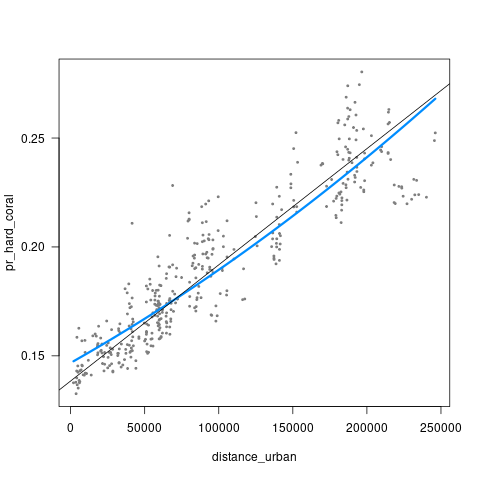

In [59]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE) 
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 ,data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ distance_urban,data=df_peak_all,family=beta_family())
                   
                    
                    visreg(MOD1, scale = 'response', partial=T)
                    lmDU= lm(pr_hard_coral~distance_urban, data = df_peak_all) #Create the linear regression
                    
                    abline(lmDU)
                    print(summary(MOD0))
                    print(summary(MOD1))
                    print(summary(lmDU))
                    
                    
                    
                    


### Closest port (distance to port)

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1013.7   -993.5    511.8  -1023.7      411 

Random effects:

Conditional model:
 Groups                                       Name        Variance  Std.Dev. 
 peak2_clusters:(peak3_clusters:country_code) (Intercept) 4.434e-02 2.106e-01
 peak3_clusters:country_code                  (Intercept) 1.571e-01 3.964e-01
 country_code                                 (Intercept) 2.954e-09 5.435e-05
Number of obs: 416, groups:  
peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:country_code, 8; country_code, 4

Overdispersion parameter for beta family (): 28.3 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.5254     0.1552   -9.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 Family: beta  ( logit 

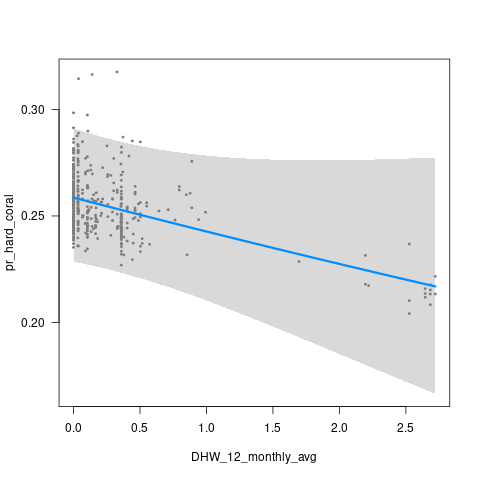

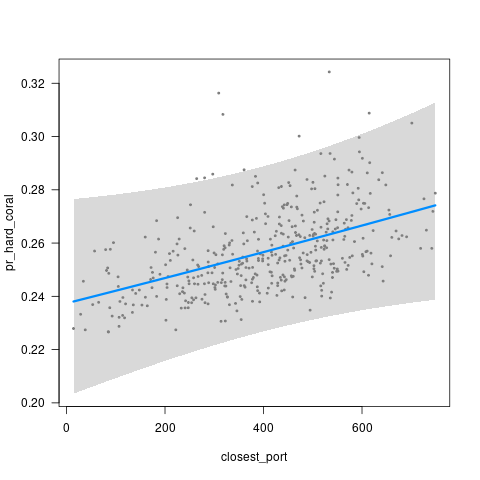

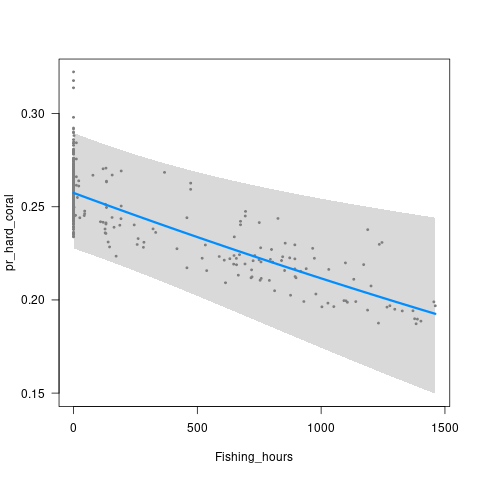

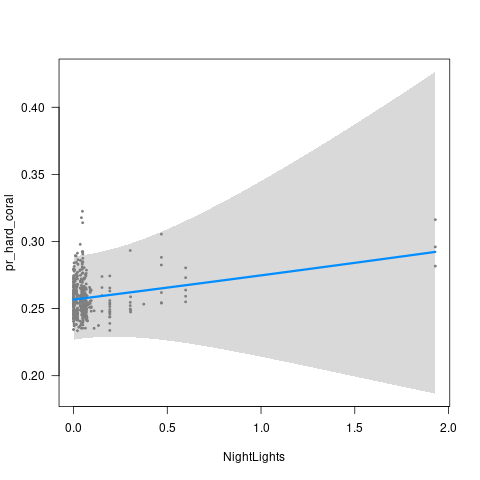

In [46]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ DHW_12_monthly_avg +closest_port   +Fishing_hours + NightLights+(1 | country_code/peak3_clusters/peak2_clusters),data=df_peak_all,family=beta_family())
                    print(summary(MOD0))
                    print(summary(MOD1))
                    
                    visreg(MOD1, scale = 'response', partial=T)

                    
                    


# Fishing hours
here I made a variable with the number of hours 1 before the survey date year ! (big approximation)
21.05 // Not usable

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1013.7   -993.5    511.8  -1023.7      411 

Random effects:

Conditional model:
 Groups                                       Name        Variance  Std.Dev. 
 peak2_clusters:(peak3_clusters:country_code) (Intercept) 4.434e-02 2.106e-01
 peak3_clusters:country_code                  (Intercept) 1.571e-01 3.964e-01
 country_code                                 (Intercept) 2.954e-09 5.435e-05
Number of obs: 416, groups:  
peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:country_code, 8; country_code, 4

Overdispersion parameter for beta family (): 28.3 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.5254     0.1552   -9.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 Family: beta  ( logit 

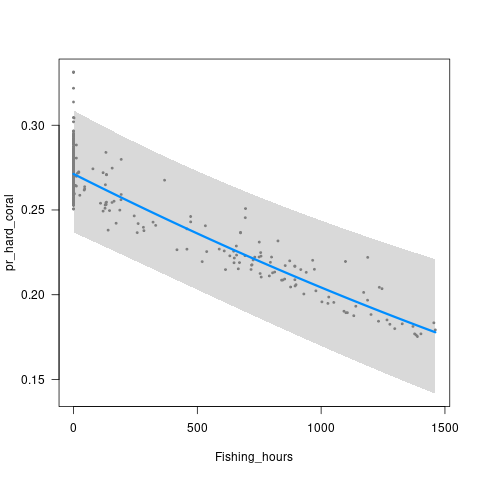

In [52]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                    completeFun <- function(data, desiredCols) {
                      completeVec <- complete.cases(data[, desiredCols])
                      return(data[completeVec, ])
                            }

                    completeFun(df_peak_all, "Fishing_hours")
                    
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ Fishing_hours  +  (1 | country_code/peak3_clusters/peak2_clusters/peak1_clusters),data=df_peak_all,family=beta_family())
                    print(summary(MOD0))
                    print(summary(MOD1))
                    
                    visreg(MOD1, scale = 'response', partial=T)
                    #library(betareg)
                    #visreg(MOD1, scale = 'response', partial=T)
                    #model = betareg(pr_hard_coral ~ fish_1_year , data = df_peak_all)
                    #print(summary(model))
                    #plot(model, which = 6)

## Nighlights 
Lookinf

Loading objects:
  df_peak_all
 Family: beta  ( logit )
Formula:          
pr_hard_coral ~ 1 + (1 | country_code/peak3_clusters/peak2_clusters)
Data: df_peak_all

     AIC      BIC   logLik deviance df.resid 
 -1013.7   -993.5    511.8  -1023.7      411 

Random effects:

Conditional model:
 Groups                                       Name        Variance  Std.Dev. 
 peak2_clusters:(peak3_clusters:country_code) (Intercept) 4.434e-02 2.106e-01
 peak3_clusters:country_code                  (Intercept) 1.571e-01 3.964e-01
 country_code                                 (Intercept) 2.954e-09 5.435e-05
Number of obs: 416, groups:  
peak2_clusters:(peak3_clusters:country_code), 15; peak3_clusters:country_code, 8; country_code, 4

Overdispersion parameter for beta family (): 28.3 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.5254     0.1552   -9.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
 Family: beta  ( logit 

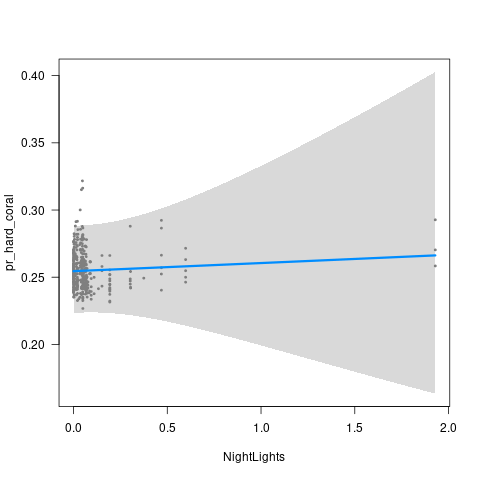

In [54]:
%%R 
library(glmmTMB)
                    library(visreg)
                    library(ggplot2)
                    library(base)
                    load("df_peak_all.rda", verbose = TRUE)
                                    completeFun <- function(data, desiredCols) {
                      completeVec <- complete.cases(data[, desiredCols])
                      return(data[completeVec, ])
                            }

                    completeFun(df_peak_all, "NightLights")
                    MOD0 = glmmTMB(pr_hard_coral ~ 1 +  (1 | country_code/peak3_clusters/peak2_clusters),data=df_peak_all,family=beta_family())
                    MOD1 = glmmTMB(pr_hard_coral ~ NightLights  +  (1 | country_code/peak3_clusters/peak2_clusters),data=df_peak_all,family=beta_family())
                    print(summary(MOD0))
                    print(summary(MOD1))
                    
                    visreg(MOD1, scale = 'response', partial=T)